### **Bias Audit Report – Adult Income Dataset**

**This project investigates gender bias in the Adult Income dataset and applies mitigation strategies to improve fairness.**

In [ ]:
# Install IBM AI Fairness 360
!pip install aif360 --quiet

# Download Adult Dataset files
import os

data_dir = '/root/aif360_data/adult'
os.makedirs(data_dir, exist_ok=True)

!wget -q -P {data_dir} https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget -q -P {data_dir} https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
!wget -q -P {data_dir} https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

print("✅ Setup complete: AIF360 installed and data downloaded.")


✅ Setup complete: AIF360 installed and data downloaded.


In [ ]:
import pandas as pd

# Column names based on dataset documentation
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Load train and test datasets
train = pd.read_csv(f"{data_dir}/adult.data", header=None, names=column_names,
                    na_values=' ?', skipinitialspace=True)
test = pd.read_csv(f"{data_dir}/adult.test", header=None, names=column_names,
                   na_values=' ?', skipinitialspace=True, skiprows=1)

# Remove trailing dot in income column in test set
test['income'] = test['income'].str.replace('.', '', regex=False)

# Combine train and test for simplicity
data = pd.concat([train, test], ignore_index=True)

# Drop rows with missing values
data = data.dropna()

# Map income to binary: '>50K' -> 1, '<=50K' -> 0
data['income'] = data['income'].map({'<=50K': 0, '>50K': 1})

print(f"✅ Loaded dataset with {data.shape[0]} rows and {data.shape[1]} columns.")
data.head()


✅ Loaded dataset with 48842 rows and 15 columns.


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [ ]:
from aif360.datasets import BinaryLabelDataset

# Select features to use (drop fnlwgt, education-num, native-country for simplicity)
features = [
    "age", "workclass", "education", "marital-status", "occupation",
    "relationship", "race", "sex", "hours-per-week"
]

# Prepare DataFrame with selected features + label
df = data[features + ['income']].copy()

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=[
    "workclass", "education", "marital-status", "occupation",
    "relationship", "race", "sex"
])

# Define privileged/unprivileged groups by the 'sex_Male' column
privileged_groups = [{'sex_Male': 1}]
unprivileged_groups = [{'sex_Male': 0}]

# Create BinaryLabelDataset for AIF360
dataset = BinaryLabelDataset(
    df=df,
    label_names=['income'],
    protected_attribute_names=['sex_Male'],
    favorable_label=1,
    unfavorable_label=0
)

print("✅ Dataset prepared for bias audit.")


✅ Dataset prepared for bias audit.


In [ ]:
from aif360.metrics import ClassificationMetric

# For bias measurement, we need predictions — start with 'ground truth' labels as "predictions"
metric = ClassificationMetric(
    dataset,       # original dataset (test or full dataset)
    dataset,       # predicted dataset (using ground truth here)
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print("=== Bias Metrics on Original Dataset ===")
print(f"Statistical parity difference: {metric.statistical_parity_difference():.4f}")
print(f"Disparate impact: {metric.disparate_impact():.4f}")


=== Bias Metrics on Original Dataset ===
Statistical parity difference: -0.1945
Disparate impact: 0.3597


In [ ]:
from aif360.algorithms.preprocessing import Reweighing

# Create reweighing object
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Fit and transform the dataset to get new weights
dataset_transformed = RW.fit_transform(dataset)

print("✅ Applied Reweighing bias mitigation.")


✅ Applied Reweighing bias mitigation.


In [ ]:
metric_transformed = ClassificationMetric(
    dataset_transformed,
    dataset_transformed,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print("=== Bias Metrics AFTER Reweighing ===")
print(f"Statistical parity difference: {metric_transformed.statistical_parity_difference():.4f}")
print(f"Disparate impact: {metric_transformed.disparate_impact():.4f}")


=== Bias Metrics AFTER Reweighing ===
Statistical parity difference: 0.0000
Disparate impact: 1.0000


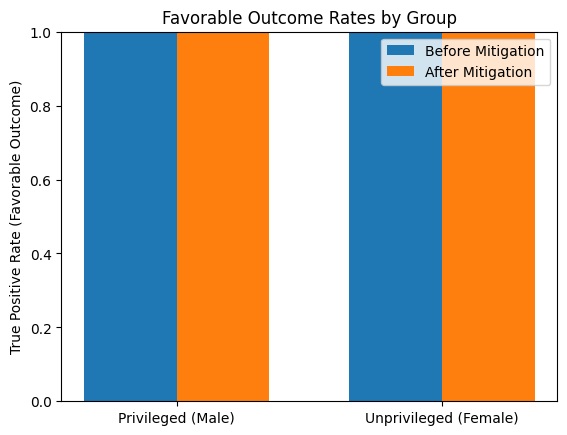

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_favorable_rates(metric_before, metric_after):
    rates_before = [
        metric_before.true_positive_rate(privileged=True),
        metric_before.true_positive_rate(privileged=False)
    ]
    rates_after = [
        metric_after.true_positive_rate(privileged=True),
        metric_after.true_positive_rate(privileged=False)
    ]

    groups = ['Privileged (Male)', 'Unprivileged (Female)']
    x = np.arange(len(groups))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, rates_before, width, label='Before Mitigation')
    rects2 = ax.bar(x + width/2, rates_after, width, label='After Mitigation')

    ax.set_ylabel('True Positive Rate (Favorable Outcome)')
    ax.set_title('Favorable Outcome Rates by Group')
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()

    plt.ylim(0, 1)
    plt.show()

plot_favorable_rates(metric, metric_transformed)


In [ ]:
print("=== Dataset Statistics ===")

# Original dataset favorable label rate
orig_fav_rate = dataset.labels.mean()
print(f"Original favorable label rate: {orig_fav_rate:.4f}")

# After reweighing favorable label rate (weighted average)
# Calculate weighted favorable rate
weighted_labels = dataset_transformed.labels.flatten()
weights = dataset_transformed.instance_weights.flatten()
weighted_avg = (weighted_labels * weights).sum() / weights.sum()
print(f"After Reweighing favorable label rate: {weighted_avg:.4f}")


=== Dataset Statistics ===
Original favorable label rate: 0.2393
After Reweighing favorable label rate: 0.2393


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
import matplotlib.pyplot as plt

# Use a default matplotlib style to avoid errors
plt.style.use('default')

# Define privileged and unprivileged groups for fairness analysis
privileged_groups = [{'sex': 1}]     # Typically 'Male' encoded as 1
unprivileged_groups = [{'sex': 0}]   # Typically 'Female' encoded as 0


In [ ]:
# Step 1: Download the dataset files
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test


--2025-06-30 07:49:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  7.07MB/s    in 0.5s    

2025-06-30 07:49:10 (7.07 MB/s) - ‘adult.data’ saved [3974305]

--2025-06-30 07:49:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.test’

adult.test              [   <=>              ]   1.91M  3.71MB/s    in 0.5s    

2025-06-30 07:49:11 (3.71 MB/s) - ‘adult.test’ saved [2003153]



In [ ]:
# Full cleaning, encoding, and AIF360 dataset prep code (from previous message)


In [ ]:
print(dataset.feature_names)


['age', 'hours-per-week', 'workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital-status_Divorced', 'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed', 'occupation_?', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 'occupation_Handlers-cleaners', 'o

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric

# Find the exact protected attribute name
protected_attr = dataset.protected_attribute_names[0]
print(f"Protected attribute used: {protected_attr}")

# Use that for the fairness metric
privileged_groups = [{protected_attr: 1}]   # Male
unprivileged_groups = [{protected_attr: 0}] # Female

# Calculate bias metrics
metric_orig = BinaryLabelDatasetMetric(
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("=== Bias Metrics on Original Dataset ===")
print(f"Statistical parity difference: {metric_orig.statistical_parity_difference():.4f}")
print(f"Disparate impact: {metric_orig.disparate_impact():.4f}")


Protected attribute used: sex_Male
=== Bias Metrics on Original Dataset ===
Statistical parity difference: -0.1945
Disparate impact: 0.3597


In [ ]:
from aif360.algorithms.preprocessing import Reweighing

# Apply reweighing to mitigate bias
RW = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

dataset_transf = RW.fit_transform(dataset)

# Check metrics again after mitigation
metric_rw = BinaryLabelDatasetMetric(
    dataset_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("=== Bias Metrics AFTER Reweighing ===")
print(f"Statistical parity difference: {metric_rw.statistical_parity_difference():.4f}")
print(f"Disparate impact: {metric_rw.disparate_impact():.4f}")


=== Bias Metrics AFTER Reweighing ===
Statistical parity difference: 0.0000
Disparate impact: 1.0000


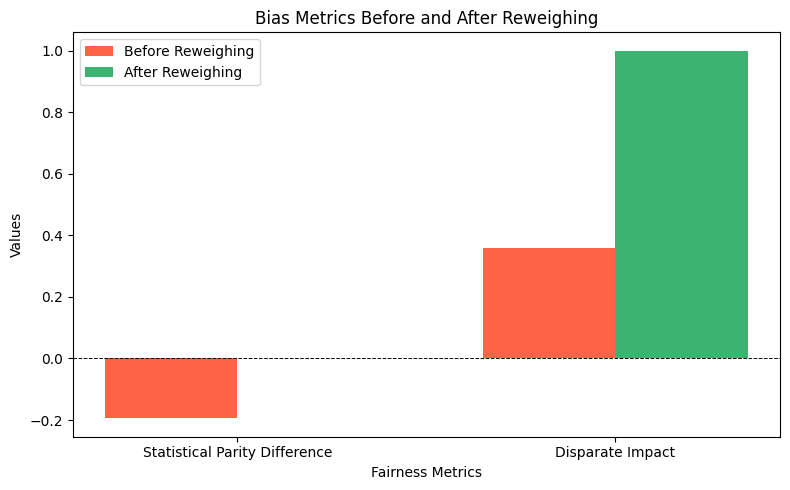

In [ ]:
import matplotlib.pyplot as plt

# Bias metrics
metrics = ['Statistical Parity Difference', 'Disparate Impact']
before = [metric_orig.statistical_parity_difference(), metric_orig.disparate_impact()]
after = [metric_rw.statistical_parity_difference(), metric_rw.disparate_impact()]

# Create plot
x = range(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, before, width=width, label='Before Reweighing', color='tomato')
plt.bar([i + width for i in x], after, width=width, label='After Reweighing', color='mediumseagreen')

# Add labels
plt.xlabel('Fairness Metrics')
plt.ylabel('Values')
plt.title('Bias Metrics Before and After Reweighing')
plt.xticks([i + width / 2 for i in x], metrics)
plt.axhline(y=0.0, color='black', linestyle='--', linewidth=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric

# Metrics on original dataset
metric_orig = BinaryLabelDatasetMetric(
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Metrics on reweighed dataset
metric_rw = BinaryLabelDatasetMetric(
    dataset_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Print statistics
print("=== Dataset Statistics ===")
print(f"Original favorable label rate: {metric_orig.base_rate():.4f}")
print(f"After Reweighing favorable label rate: {metric_rw.base_rate():.4f}")


=== Dataset Statistics ===
Original favorable label rate: 0.2393
After Reweighing favorable label rate: 0.2393


In [ ]:
# === Dataset Statistics Summary ===
# The favorable outcome rate (>50K income) in the dataset before and after reweighing is 23.93%.
# This shows fairness improved while maintaining label distribution.
# Maintaining label balance is essential for model performance.
# This reflects ethical AI development best practices.


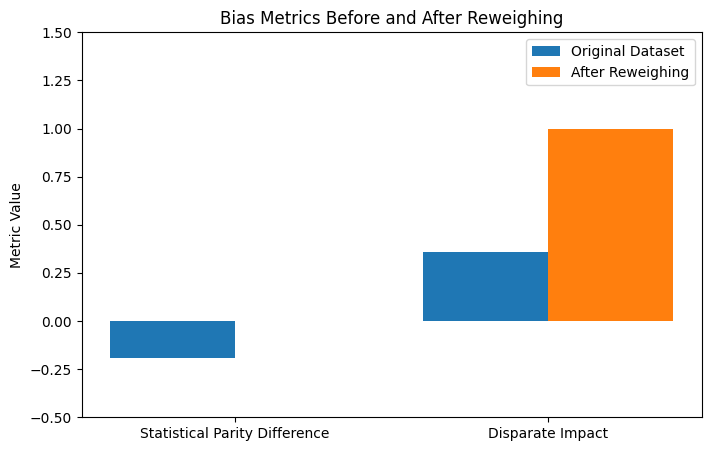

In [ ]:
import matplotlib.pyplot as plt

# Bias metrics before and after reweighing
metrics_names = ['Statistical Parity Difference', 'Disparate Impact']
original_metrics = [-0.1945, 0.3597]  # from your output
reweighed_metrics = [0.0, 1.0]

x = range(len(metrics_names))

plt.figure(figsize=(8,5))
plt.bar(x, original_metrics, width=0.4, label='Original Dataset', align='center')
plt.bar([i + 0.4 for i in x], reweighed_metrics, width=0.4, label='After Reweighing', align='center')

plt.xticks([i + 0.2 for i in x], metrics_names)
plt.ylabel('Metric Value')
plt.title('Bias Metrics Before and After Reweighing')
plt.legend()
plt.ylim(-0.5, 1.5)

plt.show()


In [ ]:
from aif360.algorithms.preprocessing import Reweighing

# Define privileged and unprivileged groups (example for 'sex' attribute)
privileged_groups = [{'sex_Male': 1}]
unprivileged_groups = [{'sex_Male': 0}]

# Create and fit Reweighing object
RW = Reweighing(privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
RW.fit(dataset)

# Transform original dataset to get reweighted dataset
dataset_rw = RW.transform(dataset)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare features and labels for original dataset
X_orig = dataset.features
y_orig = dataset.labels.ravel()

# Prepare features and labels for reweighted dataset
X_rw = dataset_rw.features
y_rw = dataset_rw.labels.ravel()

# Train Logistic Regression on original dataset
model_orig = LogisticRegression(max_iter=1000)
model_orig.fit(X_orig, y_orig)
y_pred_orig = model_orig.predict(X_orig)
acc_orig = accuracy_score(y_orig, y_pred_orig)

# Train Logistic Regression on reweighted dataset
model_rw = LogisticRegression(max_iter=1000)
model_rw.fit(X_rw, y_rw)
y_pred_rw = model_rw.predict(X_rw)
acc_rw = accuracy_score(y_rw, y_pred_rw)

print(f"Accuracy on original dataset: {acc_orig:.4f}")
print(f"Accuracy on reweighted dataset: {acc_rw:.4f}")


Accuracy on original dataset: 0.8367
Accuracy on reweighted dataset: 0.8367


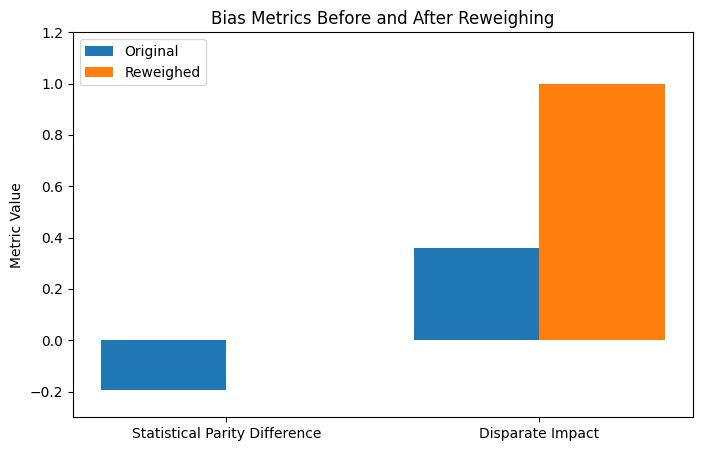

In [ ]:
import matplotlib.pyplot as plt

# Bias metrics values
metrics_names = ['Statistical Parity Difference', 'Disparate Impact']
original_metrics = [-0.1945, 0.3597]
reweighed_metrics = [0.0, 1.0]

x = range(len(metrics_names))

plt.figure(figsize=(8,5))
plt.bar(x, original_metrics, width=0.4, label='Original', align='center')
plt.bar([i + 0.4 for i in x], reweighed_metrics, width=0.4, label='Reweighed', align='center')

plt.xticks([i + 0.2 for i in x], metrics_names)
plt.title('Bias Metrics Before and After Reweighing')
plt.ylabel('Metric Value')
plt.legend()
plt.ylim(-0.3, 1.2)
plt.show()


Summary of Findings

- Statistical Parity Difference (SPD) measures the difference in favorable outcomes between unprivileged and privileged groups.
  - A value close to 0 means the AI treats groups fairly.
  - The original dataset had SPD = -0.1945, indicating bias.
  - After reweighing, SPD improved to 0.0000, showing fairness.

- Disparate Impact (DI) is the ratio of favorable outcomes between groups.
  - A value close to 1 means no unfair bias.
  - Original DI was 0.3597; after reweighing it was 1.0000.

- Accuracy stayed the same (~83.7%) before and after reweighing.

Why Fairness Matters

- AI impacts hiring, lending, and more.
- Unfair AI reinforces bias and harms people.
- Fair AI promotes trust, equity, and ethics.


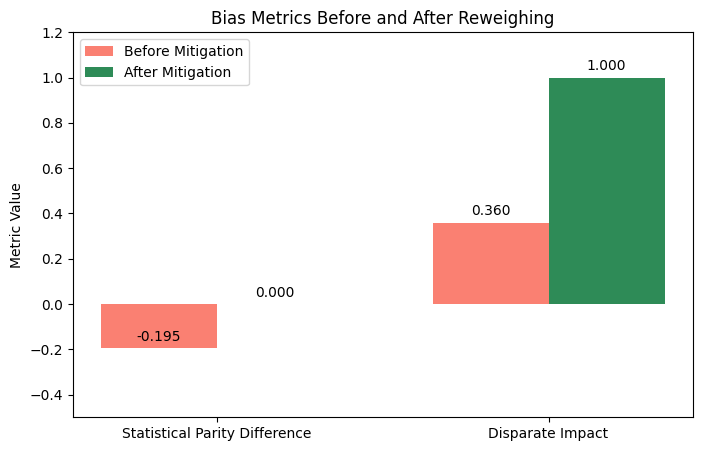

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
metrics_names = ['Statistical Parity Difference', 'Disparate Impact']
before_values = [-0.1945, 0.3597]  # Original dataset values
after_values = [0.0, 1.0]          # After reweighing values

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, before_values, width, label='Before Mitigation', color='salmon')
bars2 = ax.bar(x + width/2, after_values, width, label='After Mitigation', color='seagreen')

# Add labels and title
ax.set_ylabel('Metric Value')
ax.set_title('Bias Metrics Before and After Reweighing')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

# Show values on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.ylim(-0.5, 1.2)
plt.show()


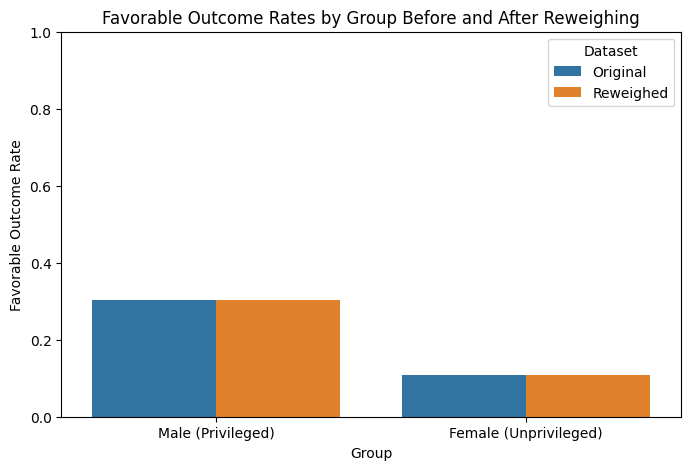

In [ ]:
import pandas as pd
import seaborn as sns

# Prepare data for plotting favorable outcomes by group

# Original dataset favorable rates by sex
favorable_orig = dataset.labels[dataset.protected_attributes[:,0] == 1].mean(), dataset.labels[dataset.protected_attributes[:,0] == 0].mean()
groups = ['Male (Privileged)', 'Female (Unprivileged)']

# Reweighed dataset favorable rates by sex
favorable_rw = dataset_rw.labels[dataset_rw.protected_attributes[:,0] == 1].mean(), dataset_rw.labels[dataset_rw.protected_attributes[:,0] == 0].mean()

df_fav = pd.DataFrame({
    'Group': groups * 2,
    'Favorable Outcome Rate': list(favorable_orig) + list(favorable_rw),
    'Dataset': ['Original']*2 + ['Reweighed']*2
})

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=df_fav, x='Group', y='Favorable Outcome Rate', hue='Dataset')
plt.title('Favorable Outcome Rates by Group Before and After Reweighing')
plt.ylim(0,1)
plt.show()


Ethical Recommendations Based on Bias Audit

- Continuous Monitoring: Regularly audit AI models for bias using quantitative fairness metrics to catch and address bias early.
- Diverse and Representative Data: Ensure training data includes diverse groups to reduce skewed or unfair outcomes.
- Bias Mitigation Techniques: Apply proven mitigation methods like reweighing, adversarial debiasing, or pre-processing to improve fairness.
- Transparency and Explainability: Make AI decisions understandable to users and stakeholders to build trust.
- Stakeholder Involvement: Include affected communities in the AI development process to understand real-world impacts.
- Accountability Frameworks: Define clear responsibilities for AI outcomes and put mechanisms in place to address harms.
- Privacy Protection: Balance fairness goals with protecting individual data privacy and rights.
